In [0]:
spark

In [0]:
import os
import json

# Load kaggle.json (assuming it’s in the '/dbfs/tmp/' directory)
with open('/Workspace/Users/jkope@gmu.edu/cs504_team3/4.0 visualizations/kaggle.json', 'r') as f: # replace with your own path
    kaggle_credentials = json.load(f)

# Set the environment variables for authentication
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Check if credentials are set correctly
print("Kaggle credentials are set")

Kaggle credentials are set


In [0]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/82.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/78.2 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.0 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=b9ea2bc731f8d99f5c5f98fa3acd45d5caf0542bef4354f51ab78ed9f6d16bf6
  Stored in directory: /root/.cache/pip/wheels/46/d2/26/84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
!kaggle datasets download -d matt2434/cleaned-ecommerce-data -p /dbfs/tmp/kaggle_data && unzip /dbfs/tmp/kaggle_data/cleaned-ecommerce-data.zip -d /dbfs/tmp/kaggle_data

Dataset URL: https://www.kaggle.com/datasets/matt2434/cleaned-ecommerce-data
License(s): apache-2.0
 99%|██████████████████████████████████████▌| 1.64G/1.65G [00:20<00:00, 170MB/s]
100%|██████████████████████████████████████| 1.65G/1.65G [00:20<00:00, 84.6MB/s]
Archive:  /dbfs/tmp/kaggle_data/cleaned-ecommerce-data.zip
  inflating: /dbfs/tmp/kaggle_data/2019-Dec-Cleaned.csv  
  inflating: /dbfs/tmp/kaggle_data/2019-Nov-Cleaned.csv  


In [0]:
nov_path = 'dbfs:/tmp/kaggle_data/2019-Nov-Cleaned.csv'
dec_path = 'dbfs:/tmp/kaggle_data/2019-Dec-Cleaned.csv'

novf = spark.read.csv(nov_path, header=True, inferSchema=True)
decf = spark.read.csv(dec_path, header=True, inferSchema=True)

In [0]:
df = novf.union(decf)

In [0]:
from pyspark.sql.functions import dayofweek, col, count, to_date, avg
import pandas as pd
import matplotlib.pyplot as plt

# Extract the date from the timestamp and the day of the week
df = df.withColumn("event_date", to_date(col("event_time")))
df = df.withColumn("day_of_week", dayofweek(col("event_time")))

# Group by day_of_week and date, then count the number of events per day
daily_events = df.groupBy("day_of_week", "event_date").agg(count("*").alias("daily_event_count"))

# Calculate the average number of events for each day of the week
average_events = daily_events.groupBy("day_of_week").agg(avg("daily_event_count").alias("avg_event_count"))

# Sort the days (Sunday=1, Monday=2, etc.)
average_events = average_events.orderBy("day_of_week")

# Convert to Pandas for plotting
average_events_pd = average_events.toPandas()

# Replace day numbers with day names
day_names = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
average_events_pd["day_of_week"] = average_events_pd["day_of_week"].apply(lambda x: day_names[x - 1])


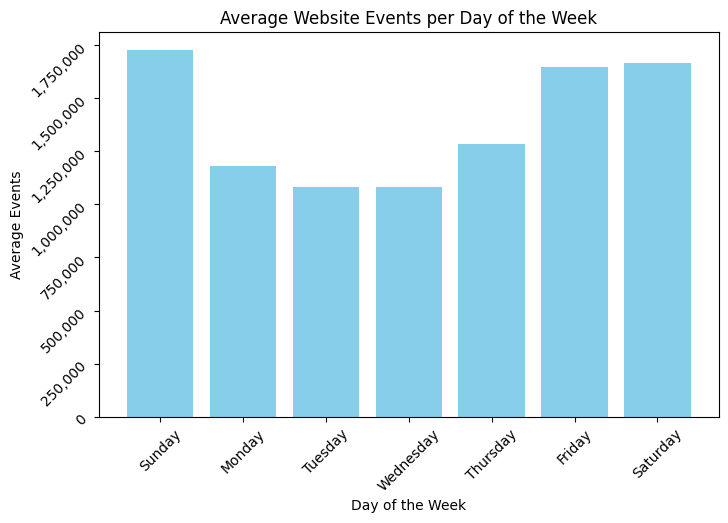

In [0]:
import matplotlib.ticker as ticker

# Plot the data
plt.figure(figsize=(8, 5))
plt.bar(average_events_pd["day_of_week"], average_events_pd["avg_event_count"], color='skyblue')
plt.title("Average Website Events per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Events")
plt.xticks(rotation=45)

# Format y-axis to show full numbers with commas
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x)))
plt.yticks(rotation=45)  # Rotate y-axis labels to 45 degrees

plt.show()


In [0]:
from pyspark.sql.functions import dayofweek, col, countDistinct, to_date, avg
import pandas as pd
import matplotlib.pyplot as plt

# Extract the date from the timestamp and the day of the week
df = df.withColumn("event_date", to_date(col("event_time")))
df = df.withColumn("day_of_week", dayofweek(col("event_time")))

# Group by day_of_week and date, then count the distinct users per day
daily_unique_visits = df.groupBy("day_of_week", "event_date").agg(countDistinct("user_id").alias("daily_unique_users"))

# Calculate the average number of unique visitors for each day of the week
average_traffic = daily_unique_visits.groupBy("day_of_week").agg(avg("daily_unique_users").alias("avg_unique_visitors"))

# Sort the days (Sunday=1, Monday=2, etc.)
average_traffic = average_traffic.orderBy("day_of_week")

# Convert to Pandas for plotting
average_traffic_pd = average_traffic.toPandas()

# Replace day numbers with day names
day_names = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
average_traffic_pd["day_of_week"] = average_traffic_pd["day_of_week"].apply(lambda x: day_names[x - 1])

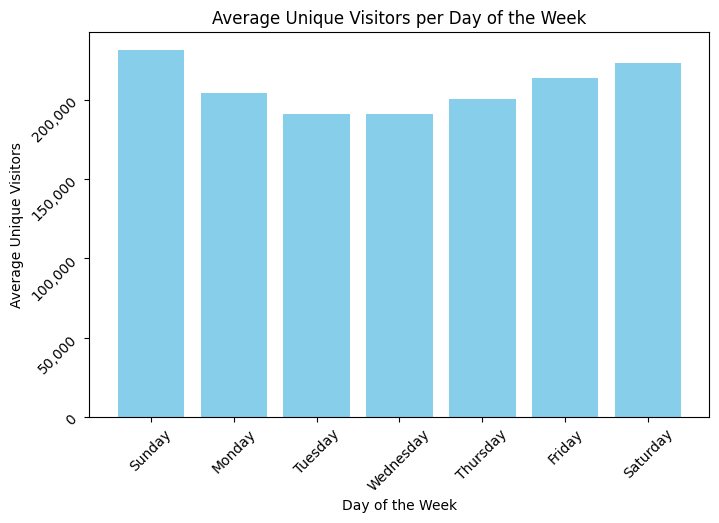

In [0]:
# Plot the data
plt.figure(figsize=(8, 5))
plt.bar(average_traffic_pd["day_of_week"], average_traffic_pd["avg_unique_visitors"], color='skyblue')
plt.title("Average Unique Visitors per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Unique Visitors")
plt.xticks(rotation=45)

# Format y-axis to show full numbers with commas
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x)))
plt.yticks(rotation=45)  # Rotate y-axis labels to 45 degrees

plt.show()
